In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from thesiscode.plotting import *

In [29]:
ysos_taurus = pd.read_csv("../contaminants/ysos_taurus_allmags.dat", ",")
ysos_taurus.varflg = ysos_taurus.varflg.astype(str).replace("nan", "nnnn")
ysos_taurus.ccflag = ysos_taurus.ccflag.astype(str).replace("nan", "HHHH")

In [5]:
lmc = pd.read_csv("../contaminants/allwise_lmc_cut.dat", "\t")
lmc = lmc[(lmc.glon < 290) & (lmc.glat > -40)]

/Users/Nick/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [7]:
def add_colors(df):
    df["coljh"] = df.jmag - df.hmag
    df["coljk"] = df.jmag - df.kmag
    df["colj1"] = df.jmag - df.w1
    df["colj2"] = df.jmag - df.w2
    df["colj3"] = df.jmag - df.w3
    df["colj4"] = df.jmag - df.w4

    df["colhk"] = df.hmag - df.kmag
    df["colh1"] = df.hmag - df.w1
    df["colh2"] = df.hmag - df.w2
    df["colh3"] = df.hmag - df.w3
    df["colh4"] = df.hmag - df.w4

    df["colk1"] = df.kmag - df.w1
    df["colk2"] = df.kmag - df.w2
    df["colk3"] = df.kmag - df.w3
    df["colk4"] = df.kmag - df.w4

    df["col12"] = df.w1 - df.w2
    df["col13"] = df.w1 - df.w3
    df["col14"] = df.w1 - df.w4
    df["col23"] = df.w2 - df.w3
    df["col24"] = df.w2 - df.w4
    df["col34"] = df.w3 - df.w4

    return df

In [6]:
def read_gator(infile):
    readin = open(infile,'r').readlines()
    data = readin[82:]

    columns = readin[78].split('|')
    colnames = []

    data_dict = {}

    for ii in range(1,len(columns)-1):
        the_name = columns[ii].strip()
        colnames.append(the_name)
        data_dict[the_name] = []

    for ii in range(len(data)):
        line = data[ii].split()
        for jj in range(len(colnames)):
            data_dict[colnames[jj]].append(line[jj])

    df = pd.DataFrame(data_dict)
    df = df.replace("null", np.nan)
    
    rename_these = {
        "designation":"wisename","cc_flags":"ccflag", 
        "dec":"decl","ext_flg":"extflg","w1mpro":"w1", 
        "w2mpro":"w2", "w3mpro":"w3", "w4mpro":"w4",
        "w1sigmpro":"w1err", "w2sigmpro":"w2err", 
        "w3sigmpro":"w3err", "w4sigmpro":"w4err",
        "j_m_2mass":"jmag", "h_m_2mass":"hmag", 
        "k_m_2mass":"kmag", "j_msig_2mass":"jerr", 
        "h_msig_2mass":"herr", "k_msig_2mass":"kerr",
        "n_2mass":"n2mass", "r_2mass":"r2mass", 
        "var_flg":"varflg"
        }
    df.rename(columns=rename_these, inplace=True)

    retype_these = "decl,ra,w1,w2,w3,w4,w1err,w2err,w3err,w4err,w1snr,w2snr,w3snr,w4snr,jmag,hmag,kmag,jerr,herr,kerr,n2mass,r2mass,extflg,glon,glat,sigra,sigdec,sigradec"
    retype_these = retype_these.split(",")
    df[retype_these] = df[retype_these].astype(float)
    
    df = add_colors(df)
    
    return df

In [8]:
def photo_cuts(df):
    sat = {"w1":2.0, "w2":1.5, "w3":-3.0, "k":8.5}
    fnt = {"w1":16.83, "w2":15.6, "w3":11.32, "k":15.5}
    snr = 3
    
    cuts = (df.w1 > sat["w1"]) & (df.w2 > sat["w2"]) & (df.w3 > sat["w3"]) & (df.kmag > sat["k"]) & (df.w1 < fnt["w1"]) & (df.w2 < fnt["w2"]) & (df.w3 < fnt["w3"]) & (df.kmag < fnt["k"]) & (df.w1snr > snr) & (df.w2snr > snr) & (df.w3snr > snr) & (df.ccflag.map(lambda flag: flag.startswith("00")))

    return df[cuts]

In [9]:
def agb_cuts(df):
    cuts = (df.coljk > 1.1) & (df.col23 < 2.5) & (df.col23 > -0.1)
    
    return df[cuts]

In [10]:
def remove_ysos(df):
    cuts = (df.col12 < 0.2) | (df.col12 > 0.75*df.col23 - 0.33) | (df.col12 < -1. * df.col23 + 1.5)
    
    return df[cuts]

In [11]:
def plot_radecl(df, figsize=(6,6), adjust={"left": 0.09, "right":0.87, "top":0.97, "bottom":0.1, "hspace":0.35, "wspace":0.2},
               hist=True):
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(left=adjust["left"], right=adjust["right"], top=adjust["top"], bottom=adjust["bottom"], hspace=adjust["hspace"], wspace=adjust["wspace"])
    
    xlim = [np.round(np.min(df.ra), 1), np.round(np.max(df.ra), 1)]
    ylim = [np.round(np.min(df.decl), 1), np.round(np.max(df.decl), 1)]
    
    ax = fig.add_subplot(111)
    if hist:
        xbins = np.arange(xlim[0], xlim[1]+0.25, 0.25)
        ybins = np.arange(ylim[0], ylim[1]+0.25, 0.25)
        H, xed, yed = np.histogram2d(df.ra, df.decl, bins=(xbins, ybins))
        extent = [xed[0], xed[-1], yed[0], yed[-1]]
        ax.imshow(np.log10(H.T), aspect="auto", extent=extent, interpolation="nearest", origin="lower", cmap=plt.cm.Greys_r)
        
    else:
        ax.scatter(df.ra, df.decl, s=1, edgecolor="None", c='k')
    
    ax.set_xlabel("RA (deg)")
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylabel("Dec (deg)")
    ax.set_ylim(ylim[0], ylim[1])
    ax.minorticks_on()
    
    plt.show()

In [25]:
def overplot_distr(df_bkg, df_top, figsize=(6,6), adjust={"left": 0.09, "right":0.85, "top":0.97, "bottom":0.1, "hspace":0.35, "wspace":0.2}, 
                   galactic=False, size=10, savefig=None, colorbar=False):
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(left=adjust["left"], right=adjust["right"], top=adjust["top"], bottom=adjust["bottom"], hspace=adjust["hspace"], wspace=adjust["wspace"])
    
    if galactic:
        xlim = [np.round(np.min(df_bkg.glon), 1), np.round(np.max(df_bkg.glon), 1)]
        ylim = [np.round(np.min(df_bkg.glat), 1), np.round(np.max(df_bkg.glat), 1)]

        xbins = np.arange(xlim[0], xlim[1]+0.25, 0.25)
        ybins = np.arange(ylim[0], ylim[1]+0.25, 0.25)
        H_bkg, xed, yed = np.histogram2d(df_bkg.glon, df_bkg.glat, bins=(xbins, ybins))
        extent = [xed[0], xed[-1], yed[0], yed[-1]]

        ax1 = plt.subplot(111)    
        imap = ax1.imshow(np.log10(H_bkg.T), aspect="auto", extent=extent, interpolation="nearest", origin="lower", cmap=plt.cm.Greys_r)
        ax1.scatter(df_top.glon, df_top.glat, s=size, c='r', marker="x")

        if colorbar:
            cax = fig.add_axes([0.86, 0.1, 0.04, 0.87]) 
            cbar = plt.colorbar(imap, cax = cax)
            cbar.ax.set_ylabel("log$_{10}$ N objects", fontsize=12)

        #============ formatting

        ax1.set_xlabel("gal l (deg)")
        ax1.set_xlim(xlim[0], xlim[1])
        ax1.set_ylabel("gal b (deg)")
        ax1.set_ylim(ylim[0], ylim[1])
        ax1.minorticks_on()    
        
    else:
        xlim = [np.round(np.min(df_bkg.ra), 1), np.round(np.max(df_bkg.ra), 1)]
        ylim = [np.round(np.min(df_bkg.decl), 1), np.round(np.max(df_bkg.decl), 1)]

        xbins = np.arange(xlim[0], xlim[1]+0.25, 0.25)
        ybins = np.arange(ylim[0], ylim[1]+0.25, 0.25)
        H_bkg, xed, yed = np.histogram2d(df_bkg.ra, df_bkg.decl, bins=(xbins, ybins))
        extent = [xed[0], xed[-1], yed[0], yed[-1]]

        ax1 = plt.subplot(111)    
        imap = ax1.imshow(np.log10(H_bkg.T), aspect="auto", extent=extent, interpolation="nearest", origin="lower", cmap=plt.cm.Greys_r)
        ax1.scatter(df_top.ra, df_top.decl, s=size, c='r', marker="x")

        if colorbar:
            cax = fig.add_axes([0.86, 0.1, 0.04, 0.87]) 
            cbar = plt.colorbar(imap, cax = cax)
            cbar.ax.set_ylabel("log$_{10}$ N objects", fontsize=12)


        #============ formatting

        ax1.set_xlabel("RA (deg)")
        ax1.set_xlim(xlim[0], xlim[1])
        ax1.set_ylabel("Dec (deg)")
        ax1.set_ylim(ylim[0], ylim[1])
        ax1.minorticks_on()


    if savefig:
        plt.savefig("../figures/"+savefig)
    plt.show()

In [13]:
def plot_color_color(df, x_color, y_color, xtit=None, ytit=None, hist=True, figsize=(6,6), adjust={"left": 0.09, "right":0.87, "top":0.97, "bottom":0.1, "hspace":0.35, "wspace":0.2}, color="k",
                    xbounds=False, ybounds=False):
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(left=adjust["left"], right=adjust["right"], top=adjust["top"], bottom=adjust["bottom"], hspace=adjust["hspace"], wspace=adjust["wspace"])
    
    if xbounds == False:
        xlim = [np.round(np.min(df[x_color]), 1), np.round(np.max(df[x_color]), 1)]
    else:
        xlim = [xbounds[0], xbounds[1]]
        
    if ybounds == False:
        ylim = [np.round(np.min(df[y_color]), 1), np.round(np.max(df[y_color]), 1)]
    else:
        ylim = [ybounds[0], ybounds[1]]
    
    ax = fig.add_subplot(111)
    if hist:
        xbins = np.arange(xlim[0], xlim[1]+0.1, 0.1)
        ybins = np.arange(ylim[0], ylim[1]+0.1, 0.1)
        H, xed, yed = np.histogram2d(df[x_color], df[y_color], bins=(xbins, ybins))
        extent = [xed[0], xed[-1], yed[0], yed[-1]]
        ax.imshow(np.log10(H.T), aspect="auto", extent=extent, interpolation="nearest", origin="lower", cmap=plt.cm.Greys_r)
        
    else:
        ax.scatter(df[x_color], df[y_color], s=10, c=color, marker="x")
    
    ax.set_xlabel(xtit)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylabel(ytit)
    ax.set_ylim(ylim[0], ylim[1])
    ax.minorticks_on()


In [14]:
def compare_color_color(df1, df2, x_color, y_color, xtit=None, ytit=None, figsize=(6,6), adjust={"left": 0.09, "right":0.87, "top":0.97, "bottom":0.1, "hspace":0.35, "wspace":0.2}, color1="k", color2="r",
                    xbounds=False, ybounds=False, hzline=None, slant=None, vline=None, savefig=None):
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(left=adjust["left"], right=adjust["right"], top=adjust["top"], bottom=adjust["bottom"], hspace=adjust["hspace"], wspace=adjust["wspace"])
    
    if xbounds == False:
        xlim = [np.round(np.min(df1[x_color]), 1), np.round(np.max(df1[x_color]), 1)]
    else:
        xlim = [xbounds[0], xbounds[1]]
        
    if ybounds == False:
        ylim = [np.round(np.min(df1[y_color]), 1), np.round(np.max(df1[y_color]), 1)]
    else:
        ylim = [ybounds[0], ybounds[1]]
    
    ax = fig.add_subplot(111)
        
    ax.scatter(df1[x_color], df1[y_color], s=10, c="None", edgecolor=color1, marker="o")
    ax.scatter(df2[x_color], df2[y_color], s=10, c=color2, marker="x")
    
    if hzline:
        ax.plot([xlim[0], xlim[1]], [hzline,hzline], color="#00FF00", linestyle="--")
    if slant:
        x = np.linspace(xlim[0],xlim[1],10)
        for line in slant:
            y = line[0]*x + line[1]
            ax.plot(x, y, color="#00FF00", linestyle="--")
    if vline:
        ax.plot([vline,vline], [ylim[0], ylim[1]], color="#00FF00", linestyle="--")
        
    ax.set_xlabel(xtit)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylabel(ytit)
    ax.set_ylim(ylim[0], ylim[1])
    ax.minorticks_on()
    
    if savefig:
        plt.savefig("../figures/"+savefig)

    plt.show()

In [16]:
wise_field1 = photo_cuts(read_gator("../yso_work/wise_field1.tbl"))
wise_field2 = photo_cuts(read_gator("../yso_work/wise_field2.tbl"))
wise_field3 = photo_cuts(read_gator("../yso_work/wise_field3.tbl"))
wise_field4 = photo_cuts(read_gator("../yso_work/wise_field4.tbl"))

taurus_field = read_gator("../yso_work/taurus_field.tbl")


In [17]:
lmc = photo_cuts(add_colors(lmc))


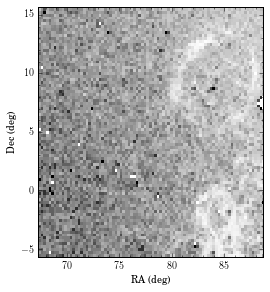

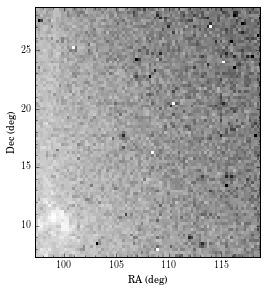

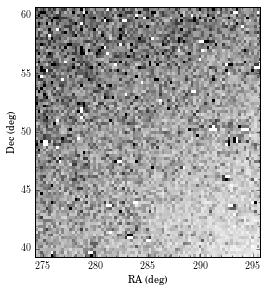

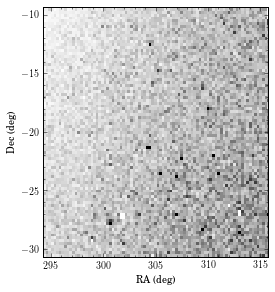

In [182]:
plot_radecl(remove_ysos(wise_field1), figsize=(4,4))
plot_radecl(remove_ysos(wise_field2), figsize=(4,4))
plot_radecl(remove_ysos(wise_field3), figsize=(4,4))
plot_radecl(remove_ysos(wise_field4), figsize=(4,4))

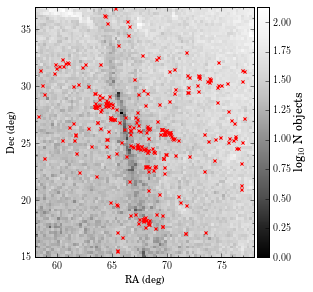

In [26]:
overplot_distr(taurus_field, ysos_taurus, figsize=(4,4), savefig="taurus_field_YSOs.pdf", colorbar=True)

In [33]:
print len(agb_cuts(photo_cuts(ysos_taurus)))
print len(agb_cuts(photo_cuts(taurus_field)))

74
6995


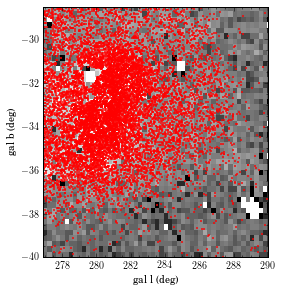

In [100]:
overplot_distr(lmc, agb_cuts(lmc), figsize=(4,4), galactic=True, size=1)

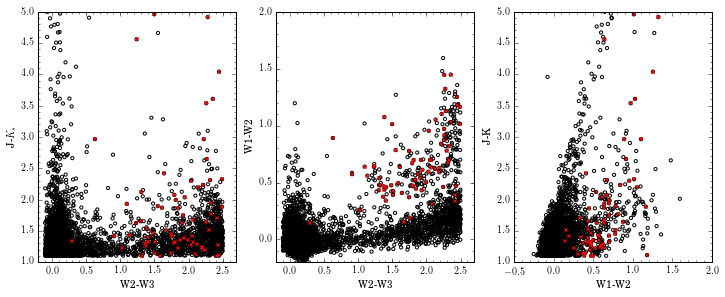

In [40]:
adjust={"left": 0.09, "right":0.87, "top":0.97, "bottom":0.1, "hspace":0.35, "wspace":0.2}
fig = plt.figure(figsize=(12,4))
fig.subplots_adjust(left=adjust["left"], right=adjust["right"], top=adjust["top"], bottom=adjust["bottom"], hspace=adjust["hspace"], wspace=adjust["wspace"])

df1 = agb_cuts(photo_cuts(taurus_field))
df2 = agb_cuts(photo_cuts(ysos_taurus))

ax = fig.add_subplot(131)
xbounds = [-0.2, 2.7]
ybounds = [1.0, 5]
xlim = [xbounds[0], xbounds[1]]
ylim = [ybounds[0], ybounds[1]]

ax.scatter(df1.col23, df1.coljk, s=10, c="None", edgecolor="k", marker="o")
ax.scatter(df2.col23, df2.coljk, s=10, c="r", marker="x")


ax.set_xlabel("W2-W3")
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylabel("J-$K_s$")
ax.set_ylim(ylim[0], ylim[1])
ax.minorticks_on()

ax = fig.add_subplot(132)
xbounds = [-0.2, 2.7]
ybounds = [-0.2, 2]
xlim = [xbounds[0], xbounds[1]]
ylim = [ybounds[0], ybounds[1]]

ax.scatter(df1.col23, df1.col12, s=10, c="None", edgecolor="k", marker="o")
ax.scatter(df2.col23, df2.col12, s=10, c="r", marker="x")


ax.set_xlabel("W2-W3")
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylabel("W1-W2")
ax.set_ylim(ylim[0], ylim[1])
ax.minorticks_on()

ax = fig.add_subplot(133)
xbounds = [-0.5, 2]
ybounds = [1.0, 5]
xlim = [xbounds[0], xbounds[1]]
ylim = [ybounds[0], ybounds[1]]

ax.scatter(df1.col12, df1.coljk, s=10, c="None", edgecolor="k", marker="o")
ax.scatter(df2.col12, df2.coljk, s=10, c="r", marker="x")


ax.set_xlabel("W1-W2")
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylabel("J-K")
ax.set_ylim(ylim[0], ylim[1])
ax.minorticks_on()

plt.savefig("../figures/ysos_taurus_color.pdf")

plt.show()

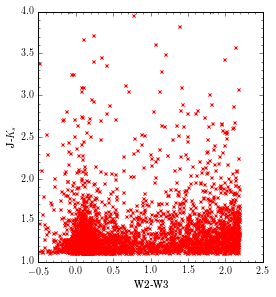

In [95]:
plot_color_color(agb_cuts(wise_field1), "col23", "coljk", "W2-W3", "J-$K_s$", hist=False, color="r", figsize=(4,4), xbounds=(-0.2,2.7), ybounds=(1.0, 4))

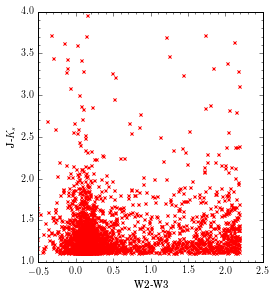

In [67]:
plot_color_color(agb_cuts(wise_field2), "col23", "coljk", "W2-W3", "J-$K_s$", hist=False, color="r", figsize=(4,4), xbounds=(-0.5,2.5), ybounds=(1.0, 4))

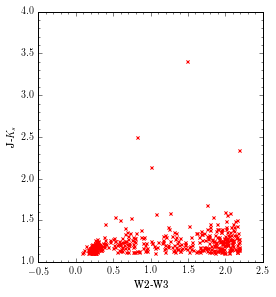

In [62]:
plot_color_color(agb_cuts(wise_field3), "col23", "coljk", "W2-W3", "J-$K_s$", hist=False, color="r", figsize=(4,4), xbounds=(-0.5,2.5), ybounds=(1.0, 4))

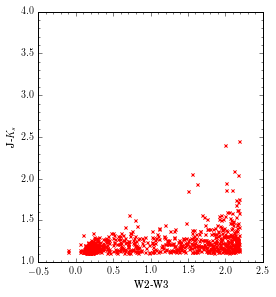

In [65]:
plot_color_color(agb_cuts(wise_field4), "col23", "coljk", "W2-W3", "J-$K_s$", hist=False, color="r", figsize=(4,4), xbounds=(-0.5,2.5), ybounds=(1.0, 4))

In [103]:
def bounds(df):
    area = (max(df.ra) - min(df.ra) + 5) * (max(df.decl) - min(df.decl) + 5)
    print df.ra.max() + 2.5, df.ra.min() - 2.5, df.decl.max() + 2.5, df.decl.min() - 2.5, area

In [105]:
agbs_lmc = agb_cuts(lmc)

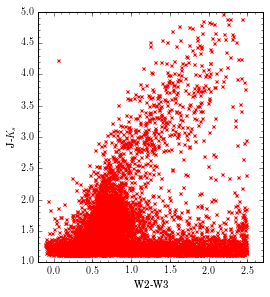

In [117]:
plot_color_color(agbs_lmc, "col23", "coljk", "W2-W3", "J-$K_s$", hist=False, color="r", figsize=(4,4), xbounds=(-0.2,2.7), ybounds=(1.0, 5))

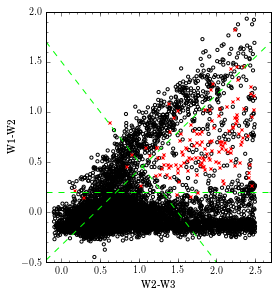

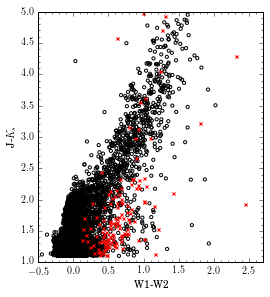

In [203]:
compare_color_color(agbs_lmc, agb_cuts(ysos_taurus), "col23", "col12", "W2-W3", "W1-W2", figsize=(4,4), xbounds=(-0.2,2.7), ybounds=(-0.5, 2.0), hzline=0.2, slant=[(0.75, -0.33), (-1.,1.5)])
compare_color_color(agbs_lmc, agb_cuts(ysos_taurus), "col12", "coljk", "W1-W2", "J-$K_s$", figsize=(4,4), xbounds=(-0.5,2.7), ybounds=(1.0, 5))

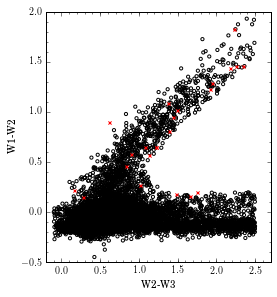

In [177]:
# newcut = (agbs_lmc.col12 < 0.2) | (agbs_lmc.col12 > 0.75*agbs_lmc.col23 - 0.33) | (agbs_lmc.col12 < -1. * agbs_lmc.col23 + 1.5)
compare_color_color(remove_ysos(agbs_lmc), remove_ysos(agb_cuts(ysos_taurus)), "col23", "col12", "W2-W3", "W1-W2", figsize=(4,4), xbounds=(-0.2,2.7), ybounds=(-0.5, 2.0))#, hzline=0.2, slant=[(0.75, -0.33), (-1.,1.5)])


In [180]:
print len(remove_ysos(agbs_lmc))/float(len(agbs_lmc))
print len(remove_ysos(agb_cuts(ysos_taurus)))/float(len(agb_cuts(ysos_taurus)) + len(remove_ysos(agb_cuts(taurus_field))))


0.981010512038
0.00390977443609


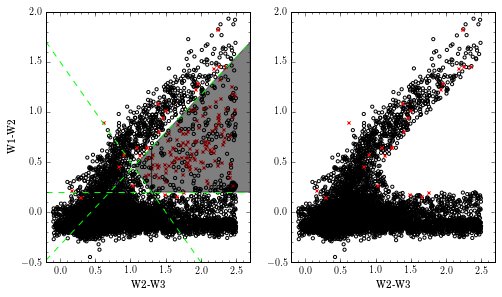

In [200]:
adjust={"left": 0.09, "right":0.87, "top":0.97, "bottom":0.1, "hspace":0.35, "wspace":0.2}
fig = plt.figure(figsize=(8,4))
fig.subplots_adjust(left=adjust["left"], right=adjust["right"], top=adjust["top"], bottom=adjust["bottom"], hspace=adjust["hspace"], wspace=adjust["wspace"])

xbounds = [-0.2, 2.7]
ybounds = [-0.5, 2.0]
xlim = [xbounds[0], xbounds[1]]
ylim = [ybounds[0], ybounds[1]]

df1 = agbs_lmc
df2 = agb_cuts(ysos_taurus)

ax = fig.add_subplot(121)

ax.scatter(df1.col23, df1.col12, s=10, c="None", edgecolor="k", marker="o")
ax.scatter(df2.col23, df2.col12, s=10, c="r", marker="x")

hzline = 0.2
slant=[(0.75, -0.33), (-1.,1.5)]

ax.plot([xlim[0], xlim[1]], [hzline, hzline], color="#00FF00", linestyle="--")
x = np.linspace(xlim[0],xlim[1],10)

for line in slant:
    y = line[0]*x + line[1]
    ax.plot(x, y, color="#00FF00", linestyle="--")

meet = 1.3
    
ax.fill_between([1.075, meet], [slant[1][0]*1.075 + slant[1][1], slant[1][0]*meet + slant[1][1]], [slant[0][0]*1.075 + slant[0][1], slant[0][0]*meet + slant[0][1]], color='k', alpha=0.5)    
ax.fill_between([meet, xlim[1]], [hzline, hzline], [slant[0][0]*meet + slant[0][1], slant[0][0]*xlim[1] + slant[0][1]], color='k', alpha=0.5)    

ax.set_xlabel("W2-W3")
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylabel("W1-W2")
ax.set_ylim(ylim[0], ylim[1])
ax.minorticks_on()


df1 = remove_ysos(agbs_lmc)
df2 = remove_ysos(agb_cuts(ysos_taurus))

ax = fig.add_subplot(122)

ax.scatter(df1.col23, df1.col12, s=10, c="None", edgecolor="k", marker="o")
ax.scatter(df2.col23, df2.col12, s=10, c="r", marker="x")

ax.set_xlabel("W2-W3")
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])
ax.minorticks_on()

plt.savefig("../figures/remove_ysos.pdf")

plt.show()

In [204]:
len(agb_cuts(taurus_field))

6995

In [205]:
len(remove_ysos(agb_cuts(taurus_field)))

6514

In [206]:
6514./6995

0.9312365975696927

In [210]:
print len(agb_cuts(ysos_taurus))/float(len(agb_cuts(ysos_taurus)) + len(agb_cuts(taurus_field)))*100
print len(remove_ysos(agb_cuts(ysos_taurus)))/float(len(remove_ysos((agb_cuts(ysos_taurus)))) + len(remove_ysos(agb_cuts(taurus_field))))*100

1.90716589539
0.39755351682


In [211]:
print len(agb_cuts(ysos_taurus))
print len(remove_ysos(agb_cuts(ysos_taurus)))

136
26


In [41]:
88.83*6514./6995

82.7217469621158